In [ ]:
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Code for some unsupervised algorithms
# Right now for individual event 1 files
# Runs k-means clustering and 
# Dayla's cool RF unsupervised algorithm, which is trained to decipher
# between frankenstein data [reproduces distribution of parameters
# but without correlations] and real data and then identifies outliers.
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import seaborn as sns


def plot_from_df(df, name, var1, var2):
    df = df.dropna()
    
    #print('this is the df you are trying to plot')
    #print(df)
 
    x = df[var1]#[0:n_points]#[np.array(binary_preds)==1]#model_lda.predict(xs)
    y = df[var2]#[0:n_points]#[np.array(binary_preds)==1]

    
    
    nbins=100#int(len(x)/10)
    
    img_data, yedges, xedges = np.histogram2d(y, x, nbins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    try:
        plt.clf()
        plt.imshow(ma.masked_where(img_data==0, img_data),  
                        rasterized=True, cmap='viridis', origin='data', extent=extent, 
                       norm=matplotlib.colors.LogNorm())
        plt.xlabel(var1)
        plt.ylabel(var2)
    
        plt.colorbar()
        plt.title(name)
        plt.show()
    except:
        plt.clf()
        plt.imshow(ma.masked_where(img_data==0, img_data),  
                        rasterized=True, cmap='viridis',  extent=extent, 
                   norm=matplotlib.colors.LogNorm())
        plt.xlabel(var1)
        plt.ylabel(var2)
        #plt.colorbar()
        plt.title(name)
        plt.show()
    
    '''plt.clf()
    plt.scatter(x, y, c = df['pha'], cmap='viridis')
    plt.colorbar()
    plt.title(name)
    plt.show()'''

In [100]:
# Import .csv files from event file
datadir = '../data/csv_files/'


id = 1505

# options: 
# science_dataframe_
# bg_dataframe_
# bg_dataframe_cutout_

# These 'science_dataframe' files are event 1 files with the gti mask applied (but no additional filtering)
data = pd.io.parsers.read_csv(datadir+'science_dataframe_'+str(id)+'.csv', sep=',')#, header=[0])
print(data)
#plot_from_df(data, 'Cas A', 'x', 'y')

         Unnamed: 0          time  crsv  crsu  amp_sf  av1   av2  av3  au1  \
0                 0  6.196317e+07    31    33       1  102   501   46   42   
1                 1  6.196317e+07    22    27       1   50   433   81   42   
2                 2  6.196318e+07    47    13       1  204   612   57  288   
3                 3  6.196318e+07    40    33       1  193   852   75  422   
4                 4  6.196318e+07     2    21       1  394   542   22   55   
...             ...           ...   ...   ...     ...  ...   ...  ...  ...   
6951805     6951805  6.201342e+07    29    31       1  314  1147   70  192   
6951806     6951806  6.201342e+07    16    57       1  192   409   28   90   
6951807     6951807  6.201342e+07    28    30       1  264  1744  148  492   
6951808     6951808  6.201342e+07    57    56       1  325   487  217   89   
6951809     6951809  6.201342e+07    32    20       1  290   416   29  265   

          au2  ...  PI exceeding 255  Event time tag is out of 

In [101]:
print(data.columns)


Index(['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of seque

In [102]:
# Prepare the fp and fb variables:
a_u = data["au1"]  # otherwise known as "a1"
b_u = data["au2"]  # "a2"
c_u = data["au3"]  # "a3"

a_v = data["av1"]
b_v = data["av2"]
c_v = data["av3"]

with np.errstate(invalid='ignore'):
    # Do the U axis
    fp_u = ((c_u - a_u) / (a_u + b_u + c_u))
    fb_u = b_u / (a_u + b_u + c_u)

    # Do the V axis
    fp_v = ((c_v - a_v) / (a_v + b_v + c_v))
    fb_v = b_v / (a_v + b_v + c_v)

data['fp_u'] = fp_u
data['fb_u'] = fb_u
data['fp_v'] = fp_v
data['fb_v'] = fb_v
data['fp_u_abs'] = abs(fp_u)
data['fp_v_abs'] = abs(fp_v)

In [146]:
# Select which predictors you want to include in the clustering:
print('options for features', data.columns[:])

all_feature_list = ['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u','fp_u_abs',
       'fb_u', 'fp_v','fp_v_abs', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of sequence', 'V amp flatness test failed',
       'U amp flatness test failed', 'V amp saturation test failed',
       'U amp saturation test failed', 'V hyperbolic test failed',
       'U hyperbolic test failed', 'Hyperbola test passed',
       'Hyperbola test failed']

feature_list = ['time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v']

# Do a clustering only in the domain we care about
feature_list = ['crsu', 'crsv','pha', 'sumamps','fp_u_abs','fb_u', 'fp_v_abs', 'fb_v']
#'x', 'y', 'pha', 'sumamps',

#feature_list = [ 'amp_sf', 'av1', 'av2', 'av3',
#       'au1', 'au2', 'au3', 'pha', 'pi', 'sumamps']

# Drop nans before you select the specific features
feature_list_xy = feature_list
feature_list_xy.extend(('x','y'))
print('feature_list_with_xy', feature_list_xy)

data = data[feature_list_xy]
data = data.dropna()

feature_list = ['crsu', 'crsv','pha', 'sumamps','fp_u_abs','fb_u', 'fp_v_abs', 'fb_v']

data_select = data[feature_list]


# Also delete nans
'''
print('len before dropping nans', len(data))
data_select = data_select.dropna()
print('len after dropping nans', len(data_select))
'''
print('options for features', data_select.columns[:])
print(feature_list)


options for features Index(['crsu', 'crsv', 'pha', 'sumamps', 'fp_u_abs', 'fb_u', 'fp_v_abs',
       'fb_v', 'x', 'y'],
      dtype='object')
feature_list_with_xy ['crsu', 'crsv', 'pha', 'sumamps', 'fp_u_abs', 'fb_u', 'fp_v_abs', 'fb_v', 'x', 'y']
options for features Index(['crsu', 'crsv', 'pha', 'sumamps', 'fp_u_abs', 'fb_u', 'fp_v_abs',
       'fb_v'],
      dtype='object')
['crsu', 'crsv', 'pha', 'sumamps', 'fp_u_abs', 'fb_u', 'fp_v_abs', 'fb_v']


In [147]:
# Standardize the data prior to k-means:

standardized_data = preprocessing.scale(data_select)
standardized_data_df = pd.DataFrame(standardized_data, columns = feature_list)
x_and_y = data[['x','y']].values#)#, columns=['x','y'])
print(standardized_data)

[[ 0.34900499  0.13309845 -2.17602499 ...  0.78357093 -1.08196152
   1.05323334]
 [-0.28732523 -0.81387873 -2.17602499 ... -0.12141821 -1.30002589
   1.01233354]
 [-1.77209573  1.81661342 -2.14657914 ...  0.08094688 -0.51039268
   0.36686099]
 ...
 [ 0.03083988 -0.18256061 -1.88156651 ...  0.73561165 -1.30811017
   1.41079574]
 [ 2.78827081  2.86881028 -2.10241037 ... -1.80981535 -0.95198312
  -1.83720398]
 [-1.02971048  0.23831813 -2.13185622 ... -2.11871492  0.78953352
  -0.94000711]]


In [148]:

print(np.shape(standardized_data))
print(feature_list)

(6900503, 8)
['crsu', 'crsv', 'pha', 'sumamps', 'fp_u_abs', 'fb_u', 'fp_v_abs', 'fb_v']


In [167]:
### Okay, why not run q quick clustering ?

nclusters=15
kmeans = KMeans(n_clusters=nclusters, random_state=42)
clusters = kmeans.fit_predict(standardized_data)
centers = kmeans.cluster_centers_#.reshape(nclusters, resampling_shape, resampling_shape)
print('centers', centers)
# These are meant to be repopulated every time you cut the galaxies
#bad_galaxies = np.zeros(np.shape(MB_matrix_rescaled))
#bad_galaxies_ifus = []

# Is it naiive to expect all of the background events to be clustered together?
# Regions of suspicion: 
# high sumamps or 
# along the rightmost side of pha
# 

centers [[ 2.96824429e-02  2.01300453e-02 -1.65414703e-01 -2.83630661e-01
  -7.15731399e-01  7.54208076e-01  1.29459662e-01  7.36564062e-02]
 [-4.01158470e-02 -1.48460812e-02  9.00016725e-01 -9.47087620e-01
   3.13270411e+00 -4.56881106e+00  2.99473739e+00 -4.19076045e+00]
 [ 4.49979222e-02  3.00680691e-02  1.17024733e+00  8.47382732e-01
  -6.63842032e-01  6.12743881e-01  8.12946116e-01 -7.70462371e-01]
 [ 5.96649066e-02  2.26829612e-02  1.16743830e+00  7.97954015e-01
   8.47377559e-01 -8.19735898e-01 -6.90468859e-01  5.84290099e-01]
 [ 2.88469947e-02  1.87460914e-02 -1.97587734e-01 -3.03192327e-01
   9.45731923e-01 -7.91315835e-01  9.20743840e-01 -7.97593513e-01]
 [-1.90932108e+00 -1.82568739e+00 -1.12115021e+00 -6.28021323e-01
   3.75014119e-02  3.24491068e-02 -5.09373321e-03  6.56713954e-02]
 [ 2.14275476e-02  1.56512924e-02 -3.11829373e-01 -3.37772539e-01
  -8.13830446e-01  8.30491729e-01  1.22499103e+00 -1.13510206e+00]
 [ 5.57524866e-02  2.35651318e-02  1.35451376e+00  1.44067780

(15, 8)
             crsu      crsv       pha   sumamps  fp_u_abs      fb_u  fp_v_abs  \
0        0.349005  0.133098 -2.176025 -2.476705 -0.549363  0.783571 -1.081962   
1       -0.287325 -0.813879 -2.176025 -2.529163 -0.026817 -0.121418 -1.300026   
2       -1.772096  1.816613 -2.146579 -2.247873  0.060532  0.080947 -0.510393   
3        0.349005  1.080076 -2.087687 -2.061999  0.612988 -0.453607 -0.949192   
4       -0.923655 -2.918272 -2.117133 -2.156175  0.149209  0.080026  1.020720   
...           ...       ...       ...       ...       ...       ...       ...   
6900498  0.136895 -0.077341 -2.014073 -1.759229 -1.590027  1.002027 -0.573134   
6900499  2.894326 -1.445197 -2.146579 -2.412682 -1.343213  1.006065  0.132524   
6900500  0.030840 -0.182561 -1.881567 -1.252411 -0.439291  0.735612 -1.308110   
6900501  2.788271  2.868810 -2.102410 -2.077282  1.053724 -1.809815 -0.951983   
6900502 -1.029710  0.238318 -2.131856 -2.394508 -0.558982 -2.118715  0.789534   

             fb_v  

<Figure size 432x288 with 0 Axes>

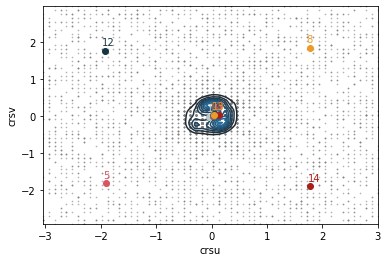

<Figure size 432x288 with 0 Axes>

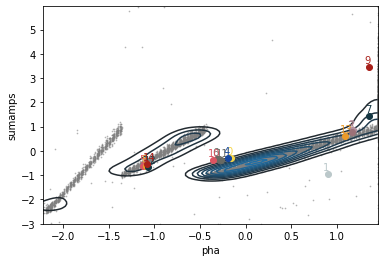

<Figure size 432x288 with 0 Axes>

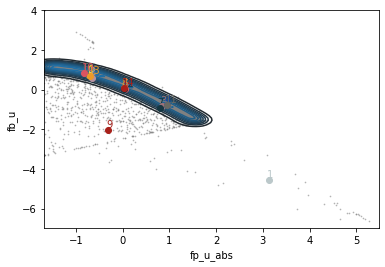

<Figure size 432x288 with 0 Axes>

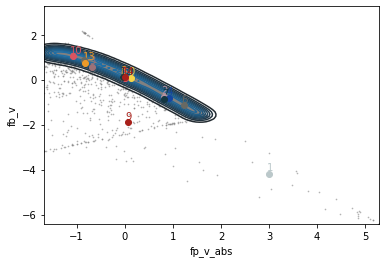

In [169]:
# Plot the centers of the clusters in these different spaces
# Do this for the pairs of features:
print(np.shape(centers))
color_array = [ '#F5D547','#BBC8CA','#B592A0','#9C7178','#1446A0',
                   '#DB5461', '#686963', '#143642', '#EC9A29', '#A8201A',
              '#DB5461', '#686963', '#143642', '#EC9A29', '#A8201A']

size_random = 10000
data_select = standardized_data_df.sample(n=size_random)

print(standardized_data_df)
print(data_select)



for i in range(int(np.shape(centers)[1]/2)):
    # Make the shape of this divided by two of plots
    
    # Get the x and y features:
    plot_x = feature_list[2*i]
    plot_y = feature_list[2*i+1]
    
    index_x = all_feature_list.index(plot_x)
    index_y = all_feature_list.index(plot_y)
    
    # Also define where the centers fall: 
    
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(data_select[plot_x].values, data_select[plot_y].values, 
               color='grey', s=0.5, alpha=0.5)
    sns.kdeplot(data_select[plot_x], data_select[plot_y], cut=0, ax = ax)#, shade_lowest=False, shade=True)
    
    
    
    for j in range(np.shape(centers)[0]):
        ax.scatter(centers[j][2*i], centers[j][2*i+1], color=color_array[j], zorder = 100)
        #print('this is the shape', np.shape(centers),'trying this cluster', j, 'and this x', 2*i, 'and this y', 2*i+1)
        ax.annotate(str(j), xy=(centers[j][2*i]-0.05, centers[j][2*i+1]+0.15), xycoords='data', color=color_array[j])
    #ax.set_aspect('equal')
    plt.show()
    
    

In [171]:
cluster={}
x_and_y_cluster = {}

for n in range(nclusters):

    cluster[n]=[]
    x_and_y_cluster[n] = []
    
    for j in range(np.shape(standardized_data)[0]):
        if clusters[j]==n:
            cluster[n].append(standardized_data[j])
            
            x_and_y_cluster[n].append(x_and_y[j])
            
    print('Cluster # ', n, ' length is ', len(cluster[n]), 
          ' fractional length is ', round(len(cluster[n])/np.shape(standardized_data)[0],2))
    
    
    
# plot each cluster individually
print(x_and_y_cluster[0])



Cluster #  0  length is  723588  fractional length is  0.1
Cluster #  1  length is  28017  fractional length is  0.0
Cluster #  2  length is  426837  fractional length is  0.06
Cluster #  3  length is  463821  fractional length is  0.07
Cluster #  4  length is  814268  fractional length is  0.12
Cluster #  5  length is  314010  fractional length is  0.05
Cluster #  6  length is  651333  fractional length is  0.09
Cluster #  7  length is  333903  fractional length is  0.05
Cluster #  8  length is  259372  fractional length is  0.04
Cluster #  9  length is  143478  fractional length is  0.02
Cluster #  10  length is  792829  fractional length is  0.11
Cluster #  11  length is  878954  fractional length is  0.13
Cluster #  12  length is  290221  fractional length is  0.04
Cluster #  13  length is  503637  fractional length is  0.07
Cluster #  14  length is  276235  fractional length is  0.04


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 432x288 with 0 Axes>

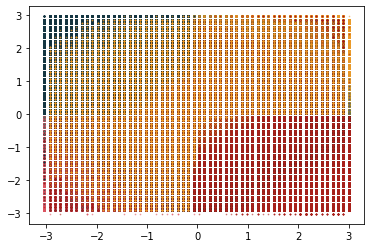

<Figure size 432x288 with 0 Axes>

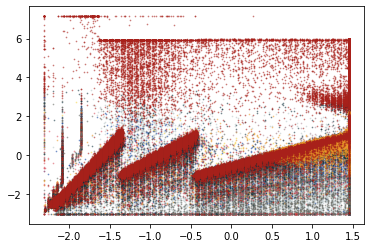

<Figure size 432x288 with 0 Axes>

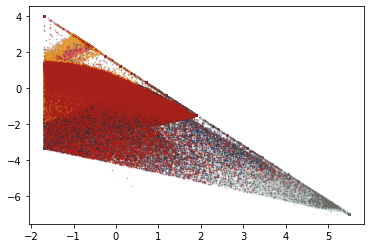

<Figure size 432x288 with 0 Axes>

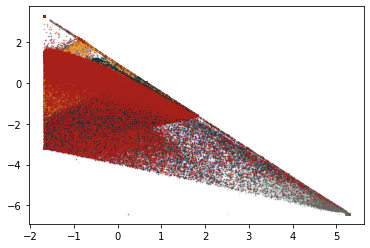

In [172]:
# Plot the points from each cluster in all of these different spaces

#color_array = ['orange','red','purple','blue','green']
for i in range(int(np.shape(centers)[1]/2)):
    # Make the shape of this divided by two of plots
    
    # Get the x and y features:
    plot_x = feature_list[2*i]
    plot_y = feature_list[2*i+1]
    
    index_x = feature_list.index(plot_x)
    index_y = feature_list.index(plot_y)
    
    
    # Also define where the centers fall: 
    
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for n in range(nclusters):
        ax.scatter(np.array(cluster[n])[:,index_x], 
                   np.array(cluster[n])[:,index_y], 
               color=color_array[n], s=0.5, alpha=0.5)
    plt.show()
 

<Figure size 432x288 with 0 Axes>

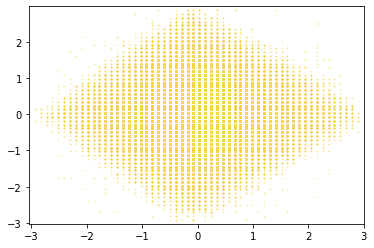

<Figure size 432x288 with 0 Axes>

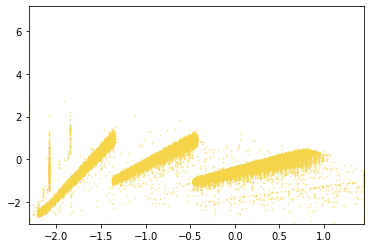

<Figure size 432x288 with 0 Axes>

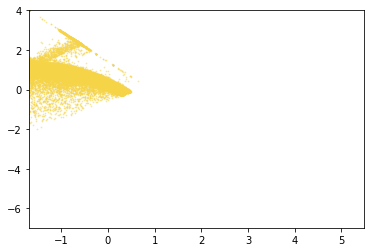

<Figure size 432x288 with 0 Axes>

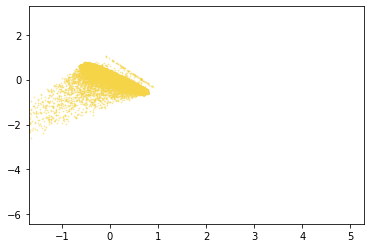

<Figure size 432x288 with 0 Axes>

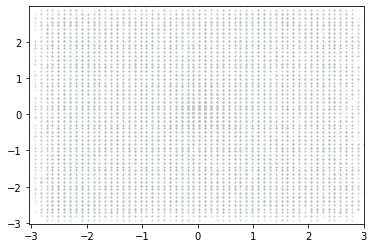

<Figure size 432x288 with 0 Axes>

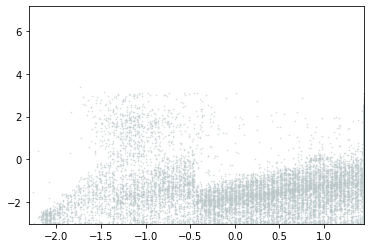

<Figure size 432x288 with 0 Axes>

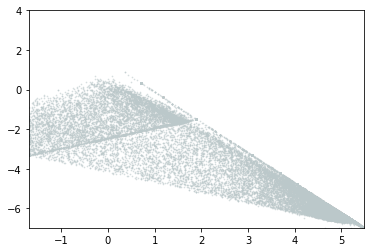

<Figure size 432x288 with 0 Axes>

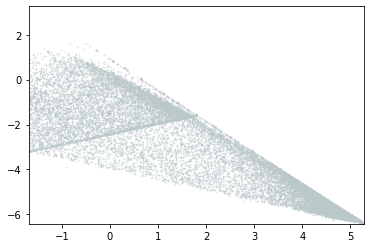

<Figure size 432x288 with 0 Axes>

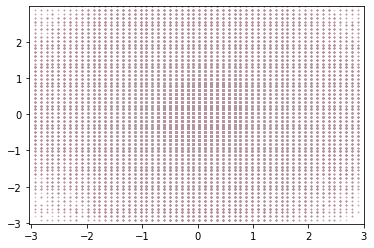

<Figure size 432x288 with 0 Axes>

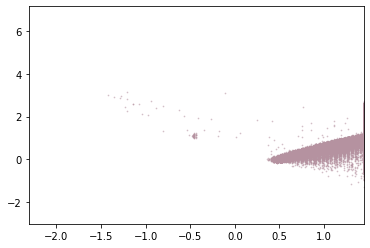

<Figure size 432x288 with 0 Axes>

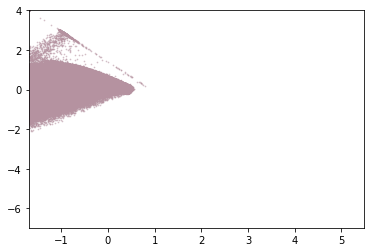

<Figure size 432x288 with 0 Axes>

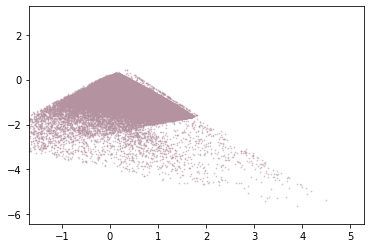

<Figure size 432x288 with 0 Axes>

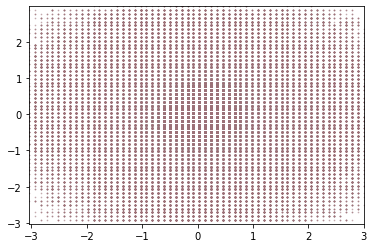

<Figure size 432x288 with 0 Axes>

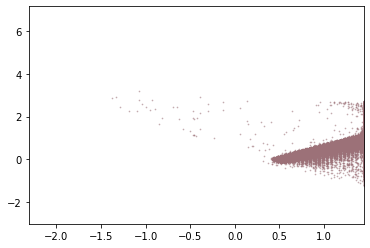

<Figure size 432x288 with 0 Axes>

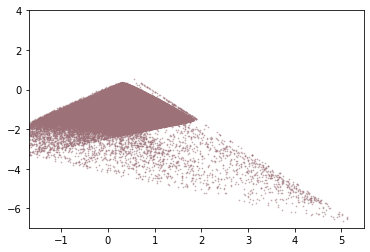

<Figure size 432x288 with 0 Axes>

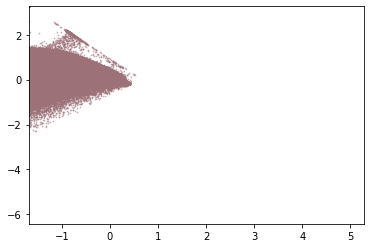

<Figure size 432x288 with 0 Axes>

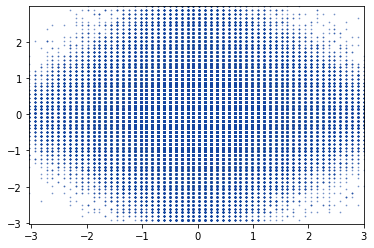

<Figure size 432x288 with 0 Axes>

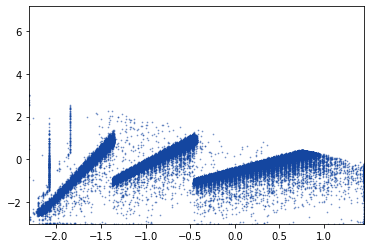

<Figure size 432x288 with 0 Axes>

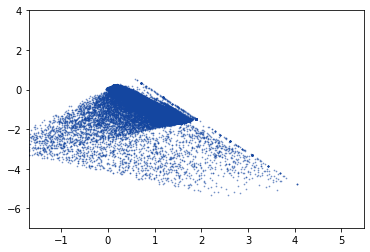

<Figure size 432x288 with 0 Axes>

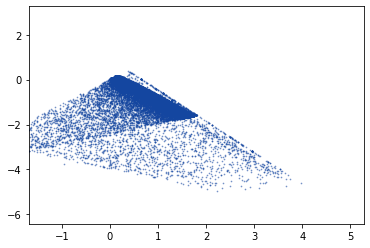

<Figure size 432x288 with 0 Axes>

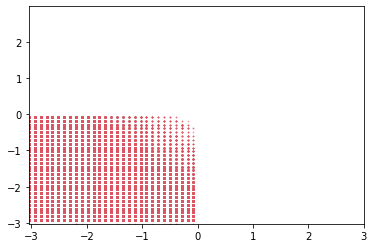

<Figure size 432x288 with 0 Axes>

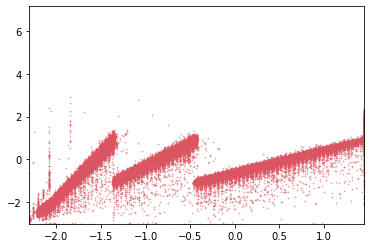

<Figure size 432x288 with 0 Axes>

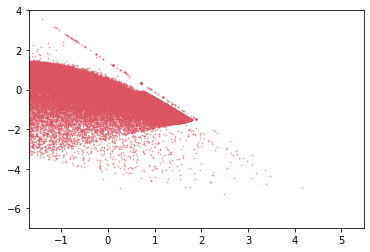

<Figure size 432x288 with 0 Axes>

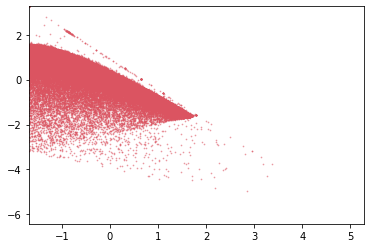

<Figure size 432x288 with 0 Axes>

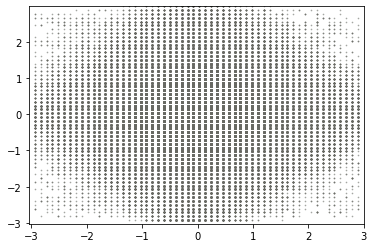

<Figure size 432x288 with 0 Axes>

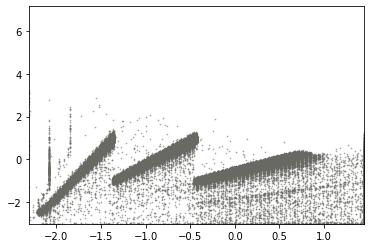

<Figure size 432x288 with 0 Axes>

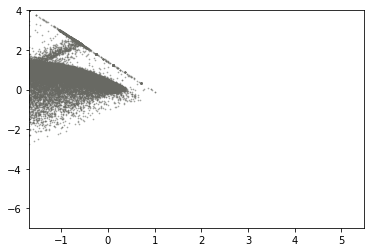

<Figure size 432x288 with 0 Axes>

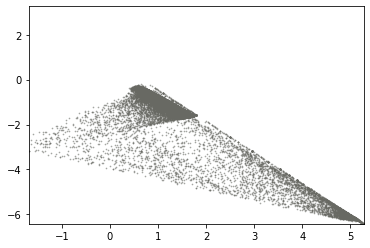

<Figure size 432x288 with 0 Axes>

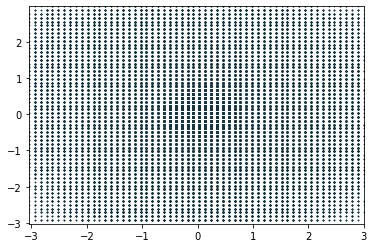

<Figure size 432x288 with 0 Axes>

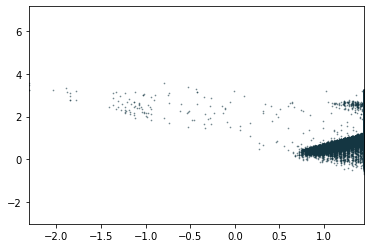

<Figure size 432x288 with 0 Axes>

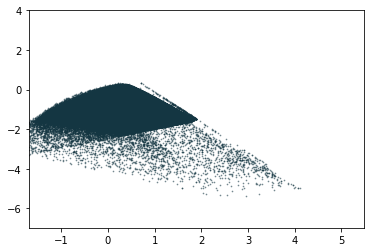

<Figure size 432x288 with 0 Axes>

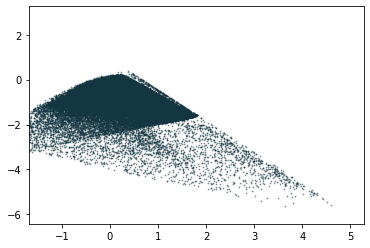

<Figure size 432x288 with 0 Axes>

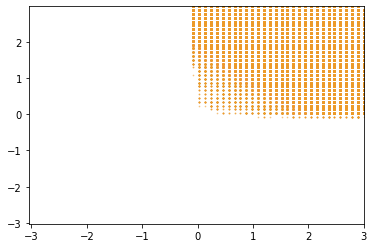

<Figure size 432x288 with 0 Axes>

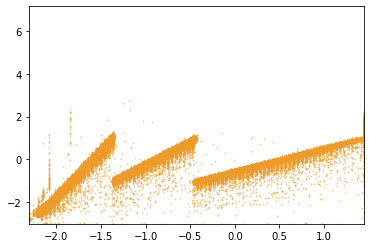

<Figure size 432x288 with 0 Axes>

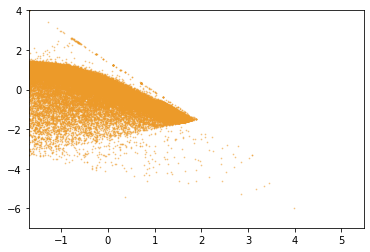

<Figure size 432x288 with 0 Axes>

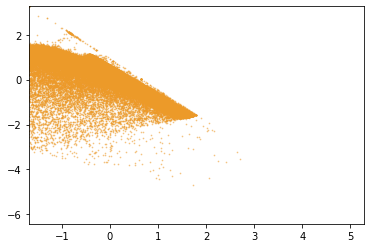

<Figure size 432x288 with 0 Axes>

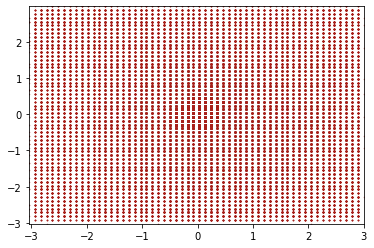

<Figure size 432x288 with 0 Axes>

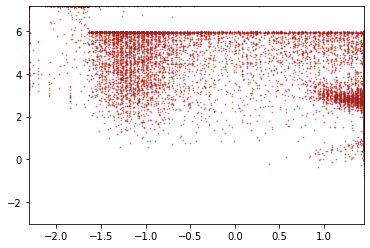

<Figure size 432x288 with 0 Axes>

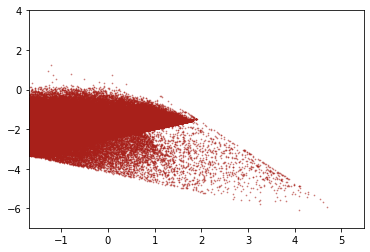

<Figure size 432x288 with 0 Axes>

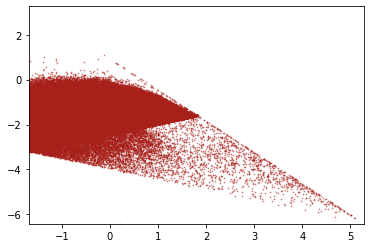

<Figure size 432x288 with 0 Axes>

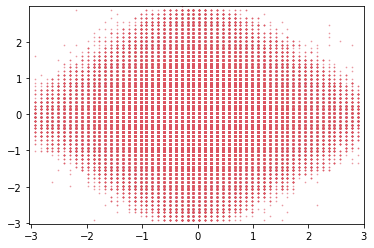

<Figure size 432x288 with 0 Axes>

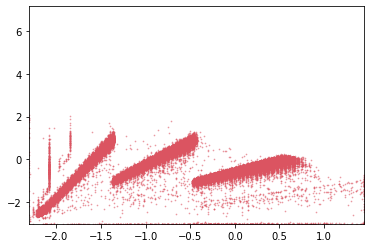

<Figure size 432x288 with 0 Axes>

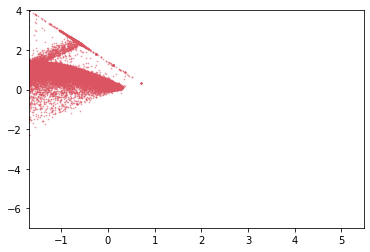

<Figure size 432x288 with 0 Axes>

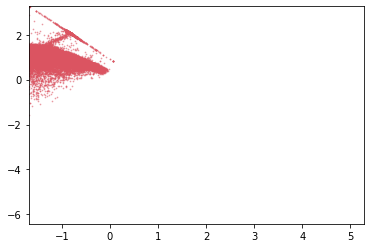

<Figure size 432x288 with 0 Axes>

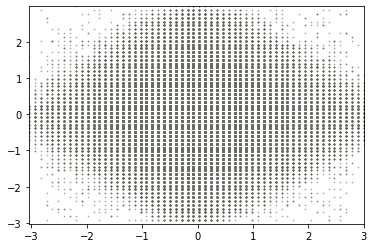

<Figure size 432x288 with 0 Axes>

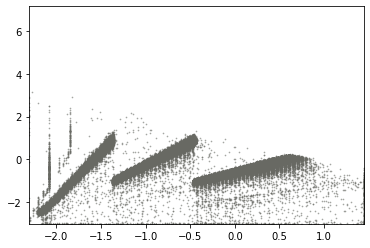

<Figure size 432x288 with 0 Axes>

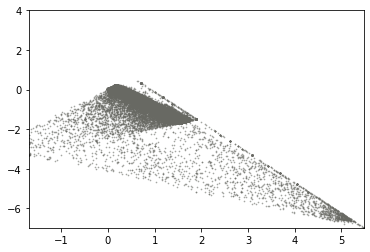

<Figure size 432x288 with 0 Axes>

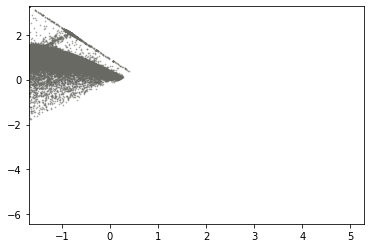

<Figure size 432x288 with 0 Axes>

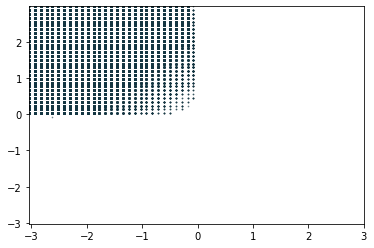

<Figure size 432x288 with 0 Axes>

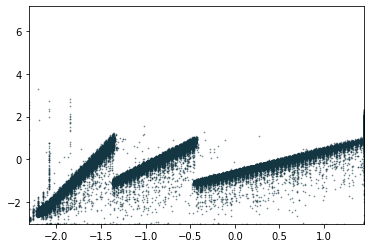

<Figure size 432x288 with 0 Axes>

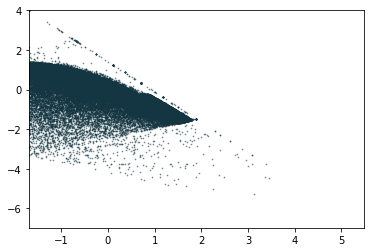

<Figure size 432x288 with 0 Axes>

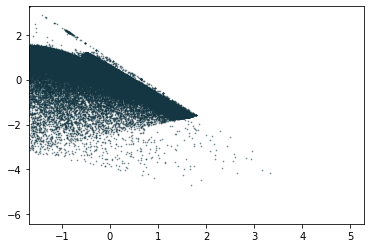

<Figure size 432x288 with 0 Axes>

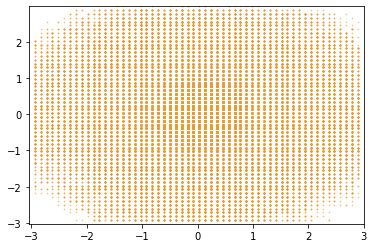

<Figure size 432x288 with 0 Axes>

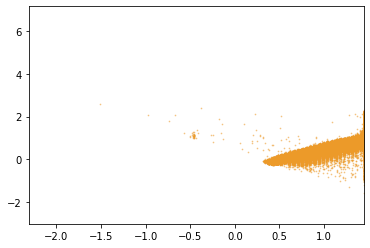

<Figure size 432x288 with 0 Axes>

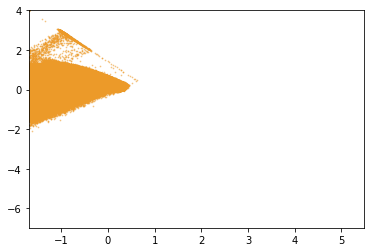

<Figure size 432x288 with 0 Axes>

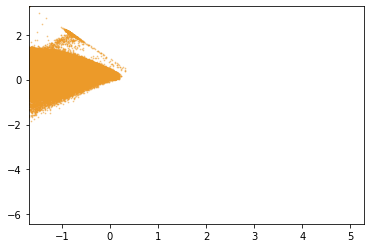

<Figure size 432x288 with 0 Axes>

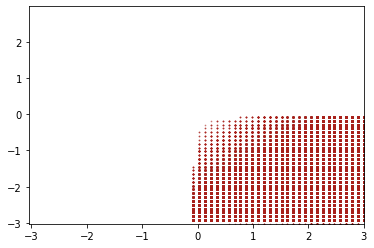

<Figure size 432x288 with 0 Axes>

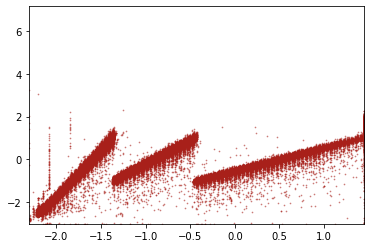

<Figure size 432x288 with 0 Axes>

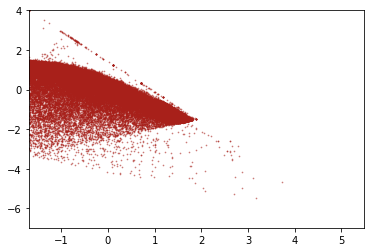

<Figure size 432x288 with 0 Axes>

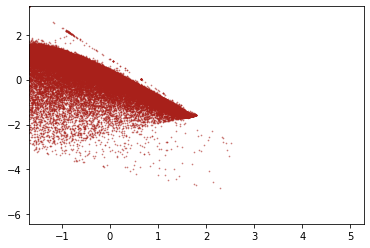

In [174]:
# Plot the points from each cluster in all of these different spaces

color_array = [ '#F5D547','#BBC8CA','#B592A0','#9C7178','#1446A0',
                   '#DB5461', '#686963', '#143642', '#EC9A29', '#A8201A',
              '#DB5461', '#686963', '#143642', '#EC9A29', '#A8201A']

for n in range(nclusters):
    for i in range(int(np.shape(centers)[1]/2)):
        # Make the shape of this divided by two of plots

        # Get the x and y features:
        plot_x = feature_list[2*i]
        plot_y = feature_list[2*i+1]

        index_x = feature_list.index(plot_x)
        index_y = feature_list.index(plot_y)


        # Also define where the centers fall: 
    
    
    
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(np.array(cluster[n])[:,index_x], 
                   np.array(cluster[n])[:,index_y], 
               color=color_array[n], s=0.5, alpha=0.5)
        ax.set_xlim([np.min(standardized_data[:,index_x]),np.max(standardized_data[:,index_x])])
        
        ax.set_ylim([np.min(standardized_data[:,index_y]),np.max(standardized_data[:,index_y])])
        plt.show()
        
        
 

(6900503, 2)
x 6481.045999999999 26216.475
y 6684.405 26388.129
Cluster # 0 723588
(723588, 2)


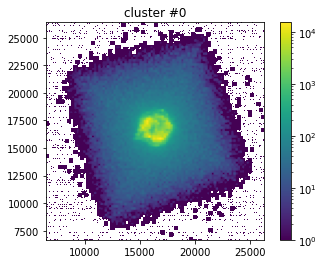

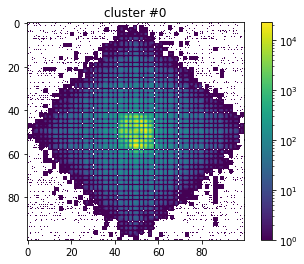

Cluster # 1 28017
(28017, 2)


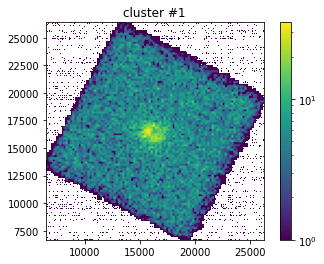

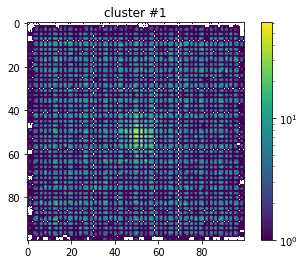

Cluster # 2 426837
(426837, 2)


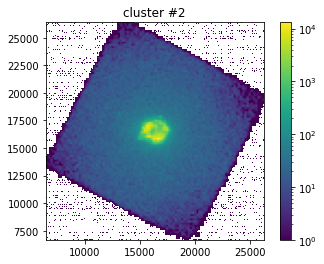

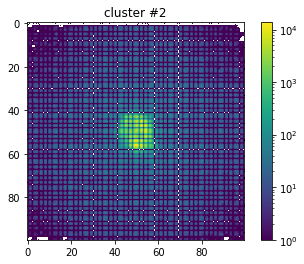

Cluster # 3 463821
(463821, 2)


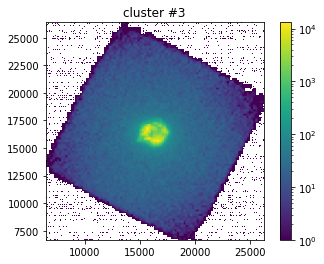

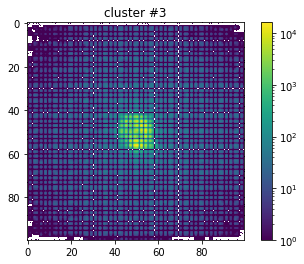

Cluster # 4 814268
(814268, 2)


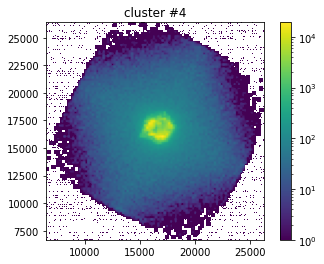

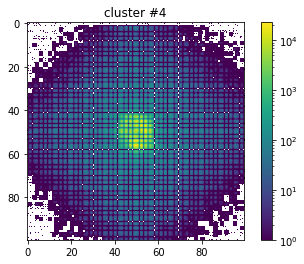

Cluster # 5 314010
(314010, 2)


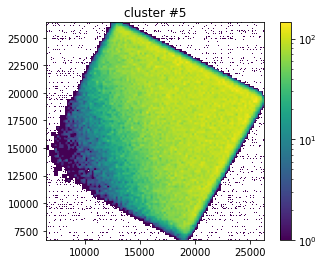

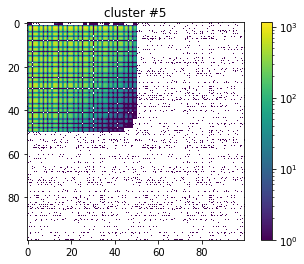

Cluster # 6 651333
(651333, 2)


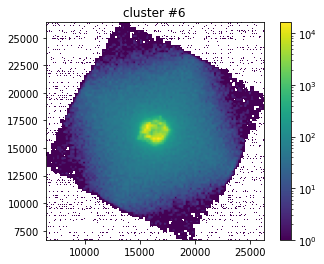

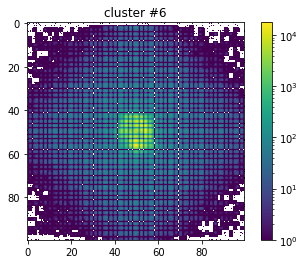

Cluster # 7 333903
(333903, 2)


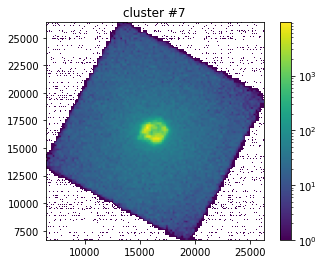

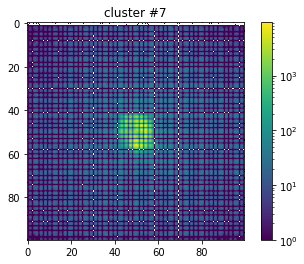

Cluster # 8 259372
(259372, 2)


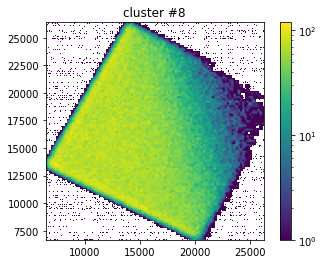

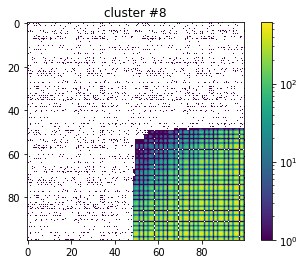

Cluster # 9 143478
(143478, 2)


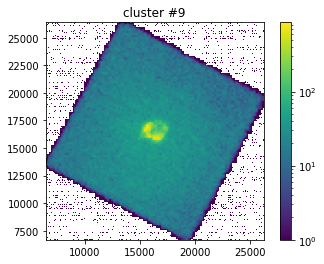

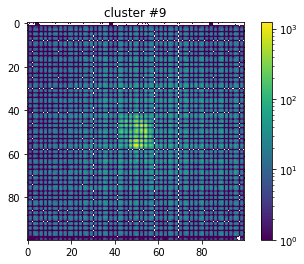

Cluster # 10 792829
(792829, 2)


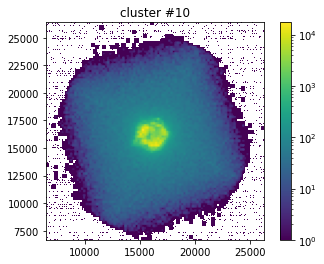

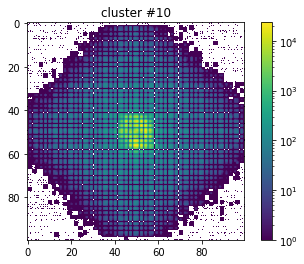

Cluster # 11 878954
(878954, 2)


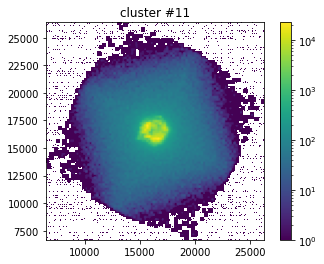

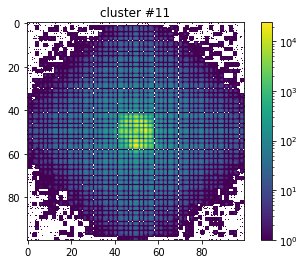

Cluster # 12 290221
(290221, 2)


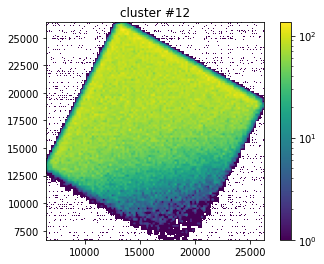

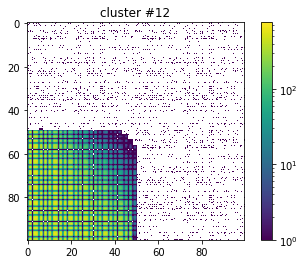

Cluster # 13 503637
(503637, 2)


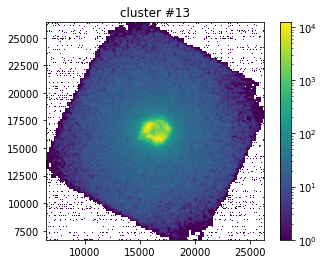

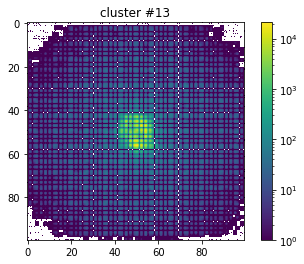

Cluster # 14 276235
(276235, 2)


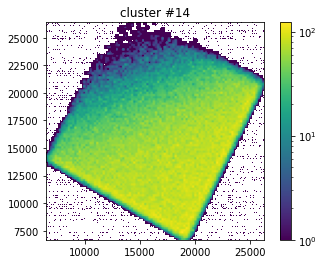

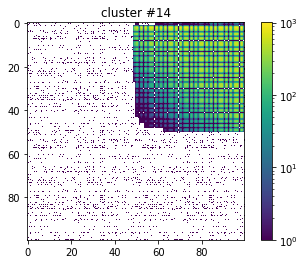

In [175]:
# Can you plot x, y images of what each cluster looks like in the data?


# Get an overall extent that is better than the individual ones:
print(np.shape(x_and_y))
print('x', np.min(x_and_y[:,0]), np.max(x_and_y[:,0]))
print('y', np.min(x_and_y[:,1]), np.max(x_and_y[:,1]))

extent_all = [np.min(x_and_y[:,0]), np.max(x_and_y[:,0]),np.min(x_and_y[:,1]), np.max(x_and_y[:,1])]
extent_all_crs = [[np.min(standardized_data[:,0]), np.max(standardized_data[:,0])],
                  [np.min(standardized_data[:,1]), np.max(standardized_data[:,1])]]
for n in range(nclusters):
    print('Cluster #', n, len(cluster[n]))
    print(np.shape(x_and_y_cluster[n]))
    
    x = np.array(x_and_y_cluster[n])[:,0]
    y = np.array(x_and_y_cluster[n])[:,1]
    
    
    nbins=100#int(len(x)/10)
    
    img_data, yedges, xedges = np.histogram2d(y, x, nbins)
    

    
    plt.clf()
    plt.imshow(abs(img_data), interpolation=None, extent=extent_all, norm=matplotlib.colors.LogNorm())#,rasterized=True, cmap='viridis', origin='data')
    

    plt.colorbar()
    plt.title('cluster #'+str(n))
    plt.show()
        
    crsu = np.array(cluster[n])[:,0]
    crsv = np.array(cluster[n])[:,1]
    
    
    nbins=100#int(len(x)/10)
    
    img_data, yedges, xedges = np.histogram2d(crsv, crsu, nbins, range = extent_all_crs)
    

    
    plt.clf()
    plt.imshow(abs(img_data), interpolation=None,  norm=matplotlib.colors.LogNorm())#,rasterized=True, cmap='viridis', origin='data')
    

    plt.colorbar()
    plt.title('cluster #'+str(n))
    plt.show()

<Figure size 432x288 with 0 Axes>

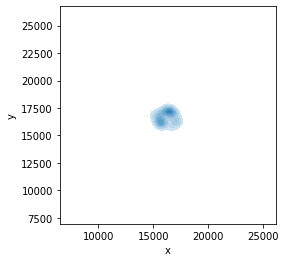

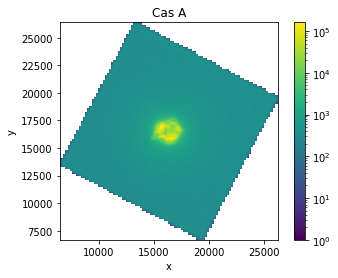

extent [[6684.405, 26623.547000000002], [6481.045999999999, 26216.475]]
Cluster #  0  length is  2045569  fractional length is  0.3
Cluster #  1  length is  4854934  fractional length is  0.7


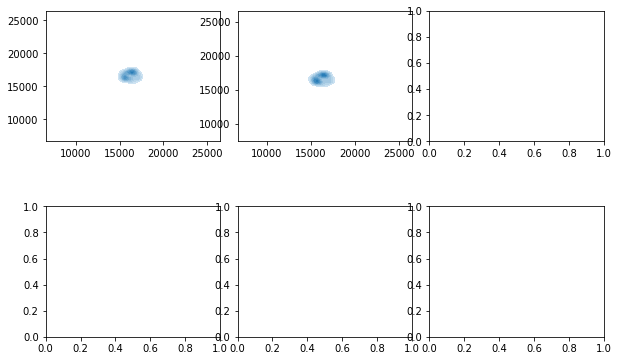

In [30]:
# Plot where the centers fall:



plt.clf()

plot_x = 'x'
plot_y = 'y'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

data_select = data.sample(n=size_random)
# Instead, use a kde plot to better show the distributions:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(data_select[plot_x], data_select[plot_y], shade_lowest=False, shade=True)
ax.set_aspect('equal')
plt.show()

plot_from_df(data, 'Cas A', plot_x, plot_y)



'''
standardized_data_df = pd.DataFrame(standardized_data, columns=feature_list)

plot_from_df(standardized_data_df, 'Cas A', plot_x, plot_y)

for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()
'''



# Classify all of the points into their proper cluster:


data_np = np.array(data)
extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]
print('extent', extent)
      


cluster={}
cluster_e={}

fig, axs = plt.subplots(2,3, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):

    print('Cluster # ', n, ' length is ', len(cluster[n]), 
          ' fractional length is ', round(len(cluster[n])/np.shape(standardized_data)[0],2))
    
    
    
    #sampled_size = cluster[n].sample(n=size_random)
    
    cluster_stack = np.vstack(cluster[n])#cluster[n]
    
    
    random_indices = np.random.choice(len(cluster[n]), size=size_random, replace=False)
    
    
    
    xs = cluster_stack[random_indices,index_x]
    ys = cluster_stack[random_indices,index_y]
    
    sns.kdeplot(xs, ys, shade_lowest=False, shade=True, ax = axs[n])
    #plt.show()
    continue
    
    nbins=100#int(len(x)/10)
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(100*len(cluster[n])/np.shape(standardized_data)[0],1))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


<Figure size 432x288 with 0 Axes>

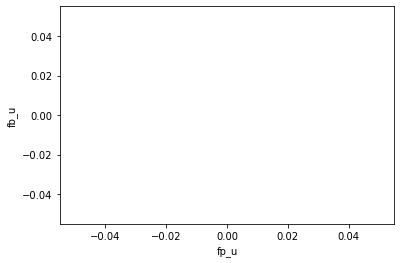

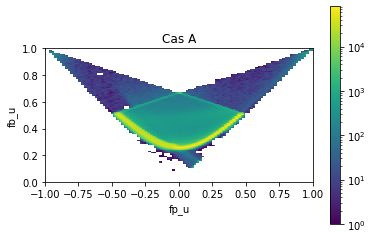

extent [[0.0, 1.0], [-0.9740518962075848, 1.0]]


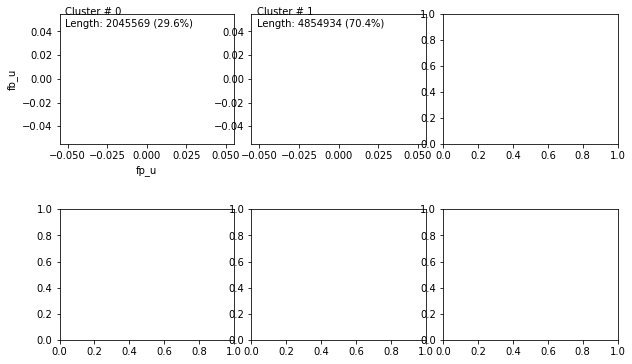

<Figure size 432x288 with 0 Axes>

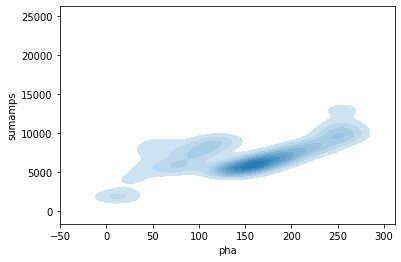

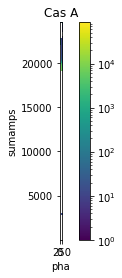

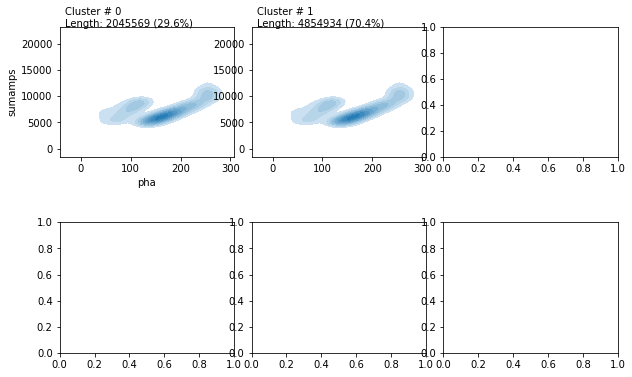

In [31]:
# Do the same thing with fp_u and fb_u
plt.clf()

plot_x = 'fp_u'
plot_y = 'fb_u'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(data_select[plot_x], data_select[plot_y], shade_lowest=False, shade=True)
#ax.set_aspect('equal')
plt.show()
plot_from_df(data, 'Cas A', plot_x, plot_y)

'''
for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()

'''


extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]
print('extent', extent)
fig, axs = plt.subplots(2,3, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):
    
    #img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    
    
    xs = cluster_stack[random_indices,index_x]
    ys = cluster_stack[random_indices,index_y]
    
    sns.kdeplot(xs, ys, shade_lowest=False, shade=True, ax = axs[n])
    
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(100*len(cluster[n])/np.shape(standardized_data)[0],1))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    #im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
    #                rasterized=True, cmap='viridis')#, origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    #plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


# Do the same thing with fp_u and fb_u
plt.clf()

plot_x = 'pha'
plot_y = 'sumamps'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(data_select[plot_x], data_select[plot_y], shade_lowest=False, shade=True)
#ax.set_aspect('equal')
plt.show()

plot_from_df(data, 'Cas A', plot_x, plot_y)
'''
for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()
'''



extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]

fig, axs = plt.subplots(2,3, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):
    
    
    xs = cluster_stack[random_indices,index_x]
    ys = cluster_stack[random_indices,index_y]
    
    #img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    sns.kdeplot(xs, ys, shade_lowest=False, shade=True, ax = axs[n])
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(100*len(cluster[n])/np.shape(standardized_data)[0],1))+'%)', 
                   xy = (0.03, 1), xycoords='axes fraction')
    
    #im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
    #                rasterized=True, cmap='viridis')#, origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    #plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


(6900503, 28)
x = fp_v
y = fb_v


<Figure size 432x288 with 0 Axes>

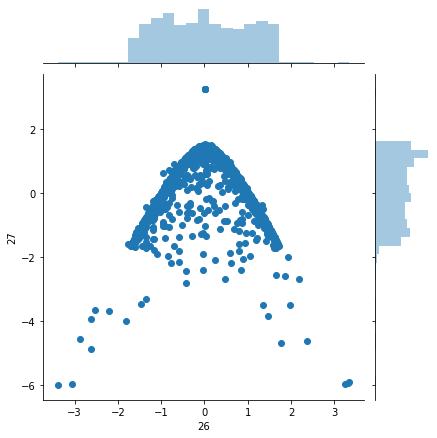

In [19]:
### Now do the RF clustering where you make frankenstein data
print(np.shape(standardized_data))
import seaborn as sns
from random import randint



plt.clf()

pix_1 = 26# This is just randomly selecting a feature in the event table
pix_2 = 27

print('x = '+feature_list[pix_1])
print('y = '+feature_list[pix_2])

x = standardized_data[0:2000,pix_1]
y = standardized_data[0:2000,pix_2]
g = (sns.jointplot(x, y)
        .set_axis_labels(str(pix_1), str(pix_2)));#, kind="hex"

913
(1000, 28)
(1000, 28)


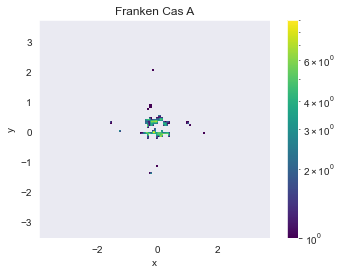

NameError: name 'STOP' is not defined

In [26]:
## Make a marginal distribution

standardized_data = standardized_data[0:1000]

value = randint(0, np.shape(standardized_data)[0])
print(value)

frankenstein_array = np.zeros(np.shape(standardized_data))

for i in range(np.shape(standardized_data)[0]):
    frankenstein_gal = []
    for j in range(np.shape(standardized_data)[1]):
        ran_int = randint(0,np.shape(standardized_data)[0] - 1)
        frankenstein_gal.append(standardized_data[ran_int,j])
    frankenstein_array[i,:] = frankenstein_gal
    
print(np.shape(frankenstein_array))
print(np.shape(standardized_data))
plot_from_df(pd.DataFrame(frankenstein_array, columns=feature_list), 'Franken Cas A', 'x', 'y')

STOP
# plot a random collection of galaxies once they have been rebinned and resized
plt.clf()
sns.set_style("dark")
fig = plt.figure(figsize = (25,15))
fig.subplots_adjust(hspace=0.3, 
                    wspace=0.15)

for j in range(6):
    ax = fig.add_subplot(1,6, j+1)
    
    ran_int = randint(0,np.shape(frankenstein_array)[0] - 1)
    
    # Plot three random versions of Cas A (uncorrelated)
    plot_from_df(pd.DataFrame(frankenstein_array[ran_int], columns=feature_list), 'Franken Cas A', 'x', 'y')

    im = ax.imshow(np.reshape(frankenstein_array[ran_int], (np.shape(MB_matrix_flat)[1],np.shape(MB_matrix_flat)[1])), cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.show()

(1000, 28)
(1000, 28)


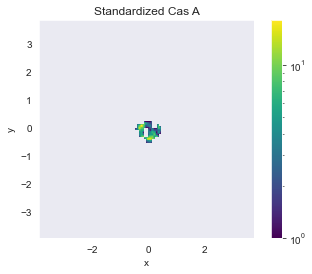

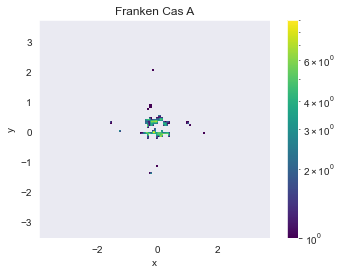

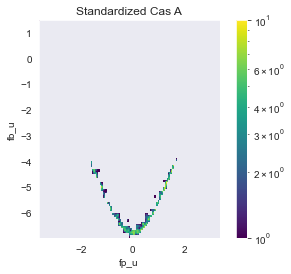

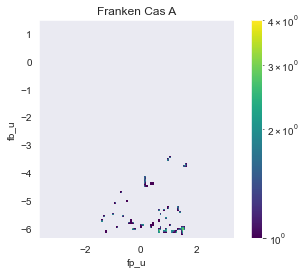

In [27]:
# Explore what the franken event file looks like 
print(np.shape(frankenstein_array))
print(np.shape(standardized_data))
plot_from_df(pd.DataFrame(standardized_data, columns = feature_list), 'Standardized Cas A', 'x', 'y')

plot_from_df(pd.DataFrame(frankenstein_array, columns = feature_list), 'Franken Cas A', 'x', 'y')


plot_from_df(pd.DataFrame(standardized_data, columns = feature_list), 'Standardized Cas A', 'fp_u', 'fb_u')

plot_from_df(pd.DataFrame(frankenstein_array, columns = feature_list), 'Franken Cas A', 'fp_u', 'fb_u')


In [28]:


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def testAndTrainIndices(test_fold, Nfolds, folds):

    print('finding test and train indices...')

    train_folds = np.delete(np.arange(Nfolds), test_fold)

    test_ind   = [i for i in range(len(folds)) if folds[i]==test_fold]
    train_ind  = [i for i in range(len(folds)) if folds[i] in train_folds]

    return test_ind, train_ind

def run_RFC(df_merg, features_list,  verbose):
    # These are adjustable RFR parameters
    Nfolds = 10
    Ndat = 5000

    features = df_merg[features_list].values
    #,'nspax','re'
    Nfeatures = len(features[0])
    
    #dat['features']#.reshape(-1,1)
    labels = df_merg[['class']].values
    folds = np.arange(len(labels))%Nfolds
    
    
    #Test on fold 0, train on the remaining folds:
    test_ind, train_ind = testAndTrainIndices(test_fold = 0, Nfolds = Nfolds, folds=folds)
    
    #divide features and labels into test and train sets:
    test_features = features[test_ind]
    test_labels   = labels[test_ind]
   
    train_features  = features[train_ind]
    train_labels    = labels[train_ind]

    print('training fold 0')
    #make a random forest model:
    model = RandomForestClassifier(max_depth=10, random_state=42)
    model.fit(train_features, train_labels)

    print('predicting...')
    # Predict on new data
    preds = model.predict(test_features)
    #print out the first few mass predictions to see if they make sense:
    if verbose:
        for h in range(10):
            print(test_labels[h], preds[h])

    #print('made it through creating model', preds)
    # rank feature importance:
    importances = model.feature_importances_
    #print('ranked importances', importances)
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    #print('std and indices', std, indices)

    if verbose:
        # Plot the feature importances of the forest
        plt.clf()
        plt.figure(figsize=(15,5))
        #plt.title("RFR Feature importances for "+str(run))
        plt.bar(range(Nfeatures), importances[indices], yerr=std[indices], align="center", color='pink')
        plt.xticks(range(Nfeatures), indices)
        plt.xlim([-1, Nfeatures])
        plt.show()
        
        #plt.savefig('feature_importance_'+str(run)+'_rando.pdf')
        
        
        
        print('Importance in Order ~~~~')
    
    # find the index of the random one:
    random_idx = features_list.index('random')
    random_value = importances[random_idx]
    random_std = std[random_idx]
    if verbose:
        print('random idx', random_idx)
        print('random_value', random_value)
    unin_here = []
    important_here = []
    for j in range(len(indices)):
        #if importances[indices[j]] - std[indices[j]] > 0:
        print(indices[j], features_list[indices[j]])
        if importances[indices[j]] > random_value:# or importances[indices[j]] - std[indices[j]] > random_value - random_std:
            important_here.append(features_list[indices[j]])
        else:
            unin_here.append(features_list[indices[j]])
        
  
    return important_here, unin_here, model



finding test and train indices...
training fold 0


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


predicting...
['real'] real
['real'] real
['real'] real
['real'] real
['real'] real
['real'] real
['real'] real
['real'] real
['real'] real
['real'] real


<Figure size 432x288 with 0 Axes>

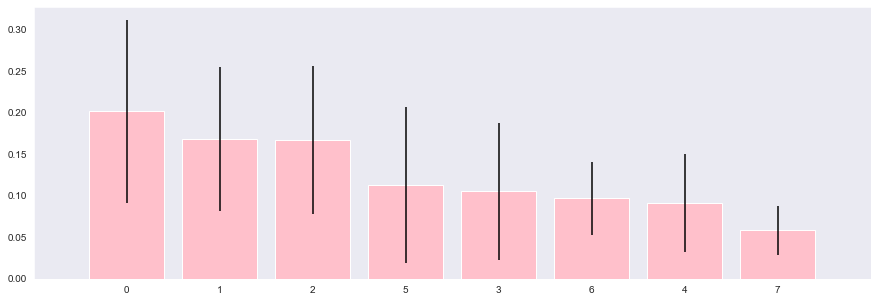

Importance in Order ~~~~
random idx 7
random_value 0.05809680632508389
0 pha
1 pi
2 sumamps
5 fp_v
3 fp_u
6 fb_v
4 fb_u
7 random


In [29]:
# Now train a random forest to distinguish between real and franken data:
# label one as ones and one as zeros

feature_list_random = ['time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3', 'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety', 'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u', 'fb_u', 'fp_v', 'fb_v', 'random']


feature_list_random = ['pha', 'pi', 'sumamps',  'fp_u', 'fb_u', 'fp_v', 'fb_v', 'random']# 'x','y', 



df_0 = pd.DataFrame(standardized_data[0:10000], columns=feature_list)#
df_1 = pd.DataFrame(frankenstein_array[0:10000], columns=feature_list)

df_0['random'] = np.random.random(len(df_0))
df_1['random'] = np.random.random(len(df_1))

df_0['class'] = 'real'
df_1['class'] = 'synthetic'

#print(df_0)
most_imp, unimportant, model  = run_RFC(pd.concat([df_0,df_1]), 
                          feature_list_random, verbose=True)



['pha', 'pi', 'sumamps', 'fp_v', 'fp_u', 'fb_v', 'fb_u'] ['random'] RandomForestClassifier(max_depth=10, random_state=42)
['real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'rea

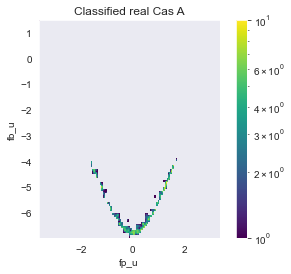

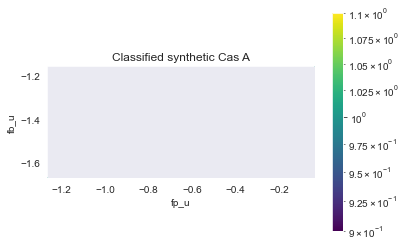

In [30]:
print(most_imp, unimportant, model)



# Now classify everything as weird or normal

predicted = model.predict(df_0[feature_list_random].values)
predict_prob = model.predict_proba(df_0[feature_list_random].values)

#print(np.bincount(predicted))
print(predicted)
print(predict_prob)
real_i = np.where(predicted=='real')[0]
not_real_i = np.where(predicted=='synthetic')[0]

print('real', len(real_i))
print('not real', len(not_real_i))

real_df = df_0[feature_list_random].values[real_i]
synthetic_df = df_0[feature_list_random].values[not_real_i]

# Now make plots out of these two 
plot_from_df(pd.DataFrame(real_df, columns = feature_list_random), 'Classified real Cas A', 'fp_u', 'fb_u')
plot_from_df(pd.DataFrame(synthetic_df, columns = feature_list_random), 'Classified synthetic Cas A', 'fp_u', 'fb_u')

In [64]:
#Wait so you need to figure out which spaxel this is
#322, where is this?

full_length = np.shape(MB_matrix_rescaled)[1]
empty = np.zeros(np.shape(MB_matrix_rescaled)[1])
for j in range(len(most_imp)):
    empty[most_imp[j]] = value[j]
    
print(empty)

# how does this show value?

'''
#side = int(np.sqrt(len(empty)))
twod = np.reshape(empty, (side,side))
plt.imshow(twod)
plt.colorbar()
plt.show()
'''

NameError: name 'MB_matrix_rescaled' is not defined